# SEMTM0031 – INFT Main Coursework  
## Question 2 – Vernon Smith (1962) Chart 5 Style Experiment (BSE)

This notebook implements a heterogeneous CDA market in BSE to approximate  
Vernon Smith's (1962) Chart 5 experimental framework:

- Human participants are replaced by **ZIP, ZIC, and SHVR** trading agents.
- The market runs over multiple **periods** with a **market shock** in the middle.
- We:
  1. Configure demand & supply schedules (before & after the shock).
  2. Run one representative BSE market session.
  3. Plot demand/supply curves **before** and **after** the shock  
     (with theoretical equilibrium prices as horizontal dotted lines).
  4. Plot transaction prices vs. transaction number (per period style),  
     with dotted lines for:
     - theoretical equilibrium price;  
     - the start/end of each period.

All parameters are chosen to be simple, transparent, and easy to reproduce.


## **1. Import Required Packages**

Below we import the necessary Python libraries and the `market_session()`  
function from **BSE.py**, as required for constructing the CDA market.


In [12]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import random
import os
from BSE import market_session


## **2. Define Global Experiment Parameters**

We configure the overall experiment timeline:

- Total duration  
- Number of periods  
- Market shock timing  
- Random seed for reproducibility  

This follows Smith’s period‐based structure, where trading pauses between periods.


In [13]:
start_time = 0
end_time = 60 * 10      

# Divide the entire session into multiple periods
period_length = 60          # 一个 period = 60 秒
n_periods = int((end_time - start_time) / period_length)

# market shock time
shock_time = int((start_time + end_time) / 2)  

random_seed = 2025
random.seed(random_seed)
# np.random.seed(random_seed)

print(f"Total time: {end_time} seconds, periods: {n_periods}, shock at t={shock_time}s")


Total time: 600 seconds, periods: 10, shock at t=300s


## **3. Pre-Shock and Post-Shock Valuation Ranges**

Following Smith (1962), we define:

- A **lower valuation range** before the shock  
- A **higher valuation range** after the shock  

The midpoint of each range serves as the **theoretical equilibrium price**.


In [14]:
# Pre-shock: supply & demand ranges
pre_range = (80, 320)          # 供给 + 需求 的初始区间（对称）

# Post-shock: only demand shifts upward, supply unchanged
post_demand_range = (300, 400) # 仅需求区间上移，供给仍用 pre_range

def midpoint(r):
    return 0.5 * (r[0] + r[1])

# 初始均衡价：直接用 pre_range 的中点
eq_pre = midpoint(pre_range)

# shock 之后的均衡价：用 供给(pre_range) 和 需求(post_demand_range) 的重叠部分算
overlap_lo = max(pre_range[0], post_demand_range[0])
overlap_hi = min(pre_range[1], post_demand_range[1])
eq_post = midpoint((overlap_lo, overlap_hi))

print(f"Pre-shock range (sup & dem): {pre_range}, eq ≈ {eq_pre:.1f}")
print(f"Post-shock demand range: {post_demand_range}, supply unchanged, eq ≈ {eq_post:.1f}")


Pre-shock range (sup & dem): (80, 320), eq ≈ 200.0
Post-shock demand range: (300, 400), supply unchanged, eq ≈ 310.0


## **4. Constructing a Two-Phase Order Schedule**

A BSE order schedule is created for both buyers and sellers:

- **Phase 1 (pre-shock):** lower price range  
- **Phase 2 (post-shock):** higher price range  

The order arrival mode uses `drip-poisson`, approximating human random arrivals.


In [15]:
supply_schedule = [
    {
        'from': start_time,
        'to': end_time,
        'ranges': [pre_range],  
        'stepmode': 'fixed'
    }
]

# Demand: shifts at shock_time
demand_schedule = [
    {
        'from': start_time,
        'to': shock_time,
        'ranges': [pre_range],          
        'stepmode': 'fixed'
    },
    {
        'from': shock_time,
        'to': end_time,
        'ranges': [post_demand_range],  
        'stepmode': 'fixed'
    }
]

order_interval = 10
order_sched = {
    'sup': supply_schedule,
    'dem': demand_schedule,
    'interval': order_interval,
    'timemode': 'drip-poisson'
}


## **5. Defining a Heterogeneous Trader Population**

Participants are replaced with equal numbers of:

- ZIP traders  
- ZIC traders  
- SHVR traders  

Both sides of the market (buyers/sellers) receive identical compositions.


In [16]:
n_zip = 10
n_zic = 10
n_shvr = 10


n_traders_per_side = n_zip + n_zic + n_shvr


sellers_spec = [
    ('ZIP',  n_zip),
    ('ZIC',  n_zic),
    ('SHVR', n_shvr),
]
buyers_spec = sellers_spec  

traders_spec = {
    'sellers': sellers_spec,
    'buyers':  buyers_spec,
}

print("Trader specification (per side):")
print(traders_spec)


Trader specification (per side):
{'sellers': [('ZIP', 10), ('ZIC', 10), ('SHVR', 10)], 'buyers': [('ZIP', 10), ('ZIC', 10), ('SHVR', 10)]}


## **6. Dump Configuration**

To minimise unnecessary output, only the **tape** (executed trades) is saved.  
This simplifies downstream plotting and keeps the environment tidy.


In [17]:
dump_flags = {
    'dump_blotters': False,
    'dump_lobs':     False,
    'dump_strats':   False,
    'dump_avgbals':  False,
    'dump_tape':     True   
}


trial_id = 'q2_smith_chart5_heterogeneous'

print("Dump flags:", dump_flags)
print("Session ID:", trial_id)


Dump flags: {'dump_blotters': False, 'dump_lobs': False, 'dump_strats': False, 'dump_avgbals': False, 'dump_tape': True}
Session ID: q2_smith_chart5_heterogeneous


## **7. Running the BSE Market Session**

A single representative run is executed.  
All random seeds are fixed to ensure consistency across runs.


In [18]:
tape_filename = trial_id + '_tape.csv'
if os.path.exists(tape_filename):
    os.remove(tape_filename)

random.seed(random_seed)
np.random.seed(random_seed)

print ("Running market session...")
market_session(
    trial_id,
    start_time,
    end_time,
    traders_spec,
    order_sched,
    dump_flags,
    sess_vrbs=False
)

print("Market session finished.")
print("Tape file generated:", tape_filename, "exists:", os.path.exists(tape_filename))


Running market session...
Market session finished.
Tape file generated: q2_smith_chart5_heterogeneous_tape.csv exists: True


## **8. Loading the Transaction Tape**

We extract:

- Trade times  
- Trade prices  
- Period membership  
- Within-period trade index  
- Equilibrium price sequence (pre-shock vs post-shock)

These data form the basis for all subsequent visual analysis.


In [19]:
times = []
prices = []

with open(tape_filename, newline='') as csvfile:
    reader = csv.reader(csvfile)
    for row in reader:
        if len(row) < 3:
            continue
        # row[0] 是 'Trd'，row[1] 时间，row[2] 价格
        t = float(row[1])
        p = float(row[2])
        times.append(t)
        prices.append(p)

times = np.array(times)
prices = np.array(prices)

n_trades = len(prices)
print(f"Total number of trades: {n_trades}")

period_index = ((times - start_time) // period_length).astype(int)
period_index = np.clip(period_index, 0, n_periods - 1)


within_period_trade_index = np.zeros(n_trades, dtype=int)
for pid in range(n_periods):
    idx = np.where(period_index == pid)[0]
    if len(idx) > 0:
        within_period_trade_index[idx] = np.arange(1, len(idx) + 1)


global_trade_index = np.arange(1, n_trades + 1)

eq_series = np.where(times < shock_time, eq_pre, eq_post)


Total number of trades: 1153


## **9. Demand & Supply Curves (Pre-Shock)**

The pre-shock environment reflects the initial low valuation range.  
Demand slopes downward; supply slopes upward.

A horizontal dotted line marks the **pre-shock equilibrium price**.


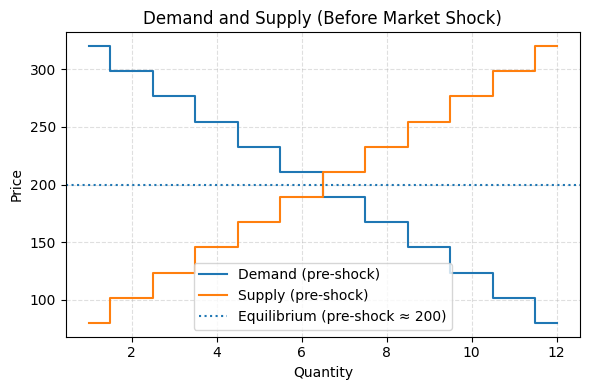

In [20]:
def build_demand_supply(price_range, n_points=10):
    p_min, p_max = price_range
    q = np.arange(1, n_points + 1)
    demand_prices = np.linspace(p_max, p_min, n_points)
    supply_prices = np.linspace(p_min, p_max, n_points)
    return q, demand_prices, supply_prices

q_pre, dem_pre, sup_pre = build_demand_supply(pre_range, n_points=12)

plt.figure(figsize=(6, 4))
plt.step(q_pre, dem_pre, where='mid', label='Demand (pre-shock)')
plt.step(q_pre, sup_pre, where='mid', label='Supply (pre-shock)')
plt.axhline(eq_pre, linestyle='dotted', label=f'Equilibrium (pre-shock ≈ {eq_pre:.0f})')

plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Demand and Supply (Before Market Shock)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


## **10. Demand & Supply Curves (Post-Shock)**

The market shock shifts both schedules upward.  
This mirrors Smith’s “shifted valuation” mechanism in Chart 5.

A new dotted line marks the **post-shock equilibrium**.


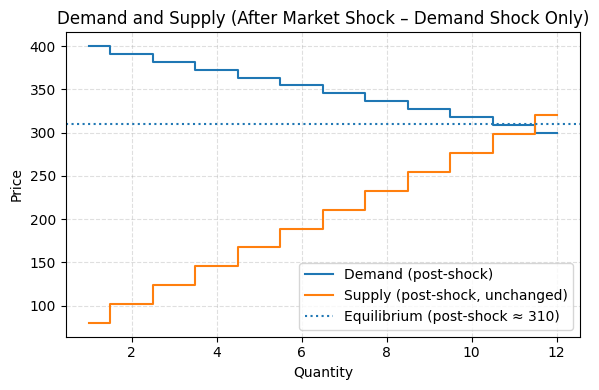

In [21]:
q_post, dem_post, _ = build_demand_supply(post_demand_range, n_points=12)

plt.figure(figsize=(6, 4))
plt.step(q_post, dem_post, where='mid', label='Demand (post-shock)')
plt.step(q_pre,  sup_pre,  where='mid', label='Supply (post-shock, unchanged)')

plt.axhline(eq_post, linestyle='dotted',
            label=f'Equilibrium (post-shock ≈ {eq_post:.0f})')

plt.xlabel('Quantity')
plt.ylabel('Price')
plt.title('Demand and Supply (After Market Shock – Demand Shock Only)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


## **11. Transaction Prices Across Periods (Smith Chart 5 Style)**

This figure replicates the style of Vernon Smith’s 1962 Chart 5:

- Each dot = one transaction  
- x-axis = transaction sequence (not time)  
- Horizontal dotted line = theoretical equilibrium  
- Vertical dotted lines = period boundaries  

This mirrors Smith’s experimental method where time within a period is ignored  
and only sequential transaction dynamics are plotted.


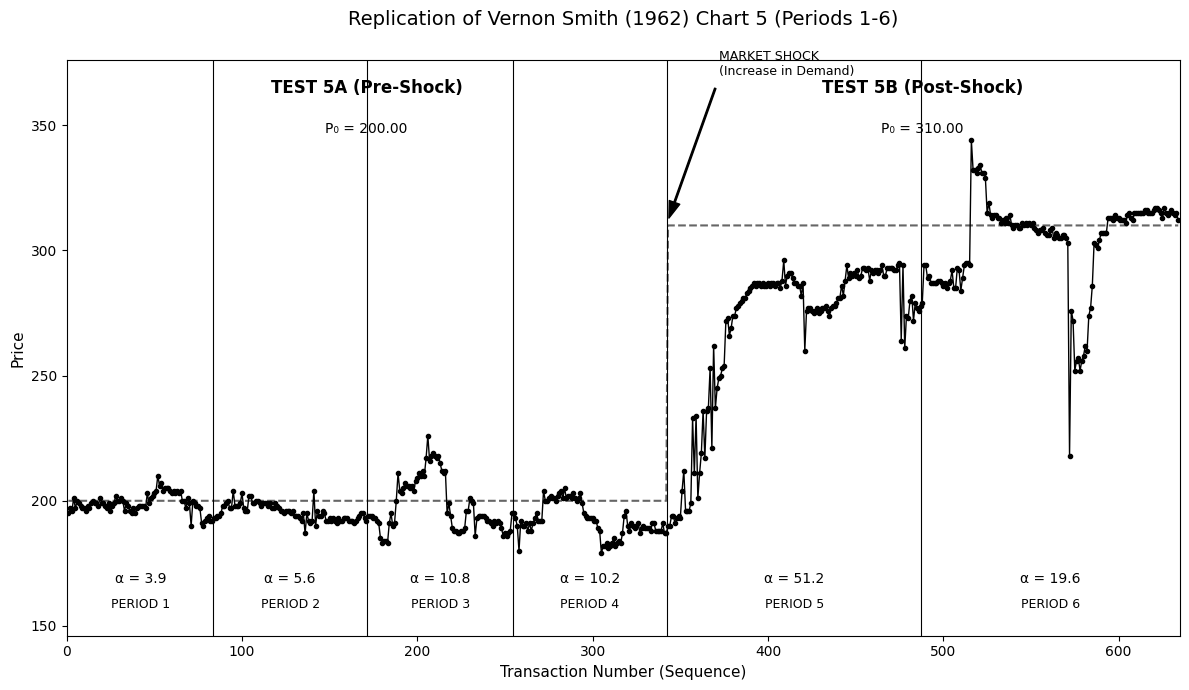

In [25]:
import numpy as np
import matplotlib.pyplot as plt

periods_to_keep = [1, 2, 3, 4, 5, 6] 
first_period_id = periods_to_keep[0] 

mask = np.isin(period_index, periods_to_keep)

prices_f = prices[mask]
period_index_f = period_index[mask]
eq_series_f = eq_series[mask]
times_f = times[mask]

n_trades_f = len(prices_f)
global_trade_index_f = np.arange(1, n_trades_f + 1)
unique_periods_f = np.unique(period_index_f)

shock_trade_idx_f = np.where(period_index_f == 5)[0][0] 

plt.figure(figsize=(12, 7))

y_min_data = min(prices_f)
y_max_data = max(prices_f)
y_min_plot = y_min_data * 0.90 

alpha_label_y_pos = y_min_plot + 5  
period_label_y_pos = y_min_plot - 5  

plt.ylim(period_label_y_pos - 10, y_max_data * 1.05 + 15)

plt.plot(global_trade_index_f, prices_f, color='black', linewidth=1.0, 
         marker='o', markersize=3, label='Transaction Price')

plt.plot(global_trade_index_f, eq_series_f, color='black', linestyle='--', 
         linewidth=1.5, alpha=0.6, label='Theoretical Equilibrium')

for pid_old in unique_periods_f:
    indices_in_period_f = np.where(period_index_f == pid_old)[0]
    
    p_trades = prices_f[indices_in_period_f]
    p_eq = eq_series_f[indices_in_period_f][0]
    alpha_val = np.sqrt(np.mean((p_trades - p_eq)**2))
    
    center_x = np.mean(global_trade_index_f[indices_in_period_f])
    
    pid_new = pid_old - first_period_id
    
    plt.text(center_x, alpha_label_y_pos, f"α = {alpha_val:.1f}", 
             ha='center', va='bottom', fontsize=10, fontweight='normal')
    
    plt.text(center_x, period_label_y_pos, f"PERIOD {pid_new+1}", 
             ha='center', va='bottom', fontsize=9)

    if pid_old > first_period_id:
        boundary_x = global_trade_index_f[indices_in_period_f][0] - 0.5
        plt.axvline(boundary_x, color='black', linestyle='-', linewidth=0.8)

center_5A = shock_trade_idx_f / 2 
center_5B = (shock_trade_idx_f + n_trades_f) / 2 

plt.text(center_5A, y_max_data * 1.05, "TEST 5A (Pre-Shock)", 
         ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.text(center_5A, y_max_data * 1.05 - 10, f"P₀ = {eq_pre:.2f}", 
         ha='center', va='top', fontsize=10)

plt.text(center_5B, y_max_data * 1.05, "TEST 5B (Post-Shock)", 
         ha='center', va='bottom', fontsize=12, fontweight='bold')
plt.text(center_5B, y_max_data * 1.05 - 10, f"P₀ = {eq_post:.2f}", 
         ha='center', va='top', fontsize=10)

plt.annotate('MARKET SHOCK\n(Increase in Demand)', 
             xy=(shock_trade_idx_f, eq_post), 
             xytext=(shock_trade_idx_f + 30, eq_post + 60), 
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=8),
             fontsize=9)

plt.xlabel('Transaction Number (Sequence)', fontsize=11)
plt.ylabel('Price', fontsize=11)
plt.title('Replication of Vernon Smith (1962) Chart 5 (Periods 1-6)', fontsize=14, pad=25)

plt.xlim(0, n_trades_f + 1)

plt.grid(False)
plt.tight_layout()
plt.show()

## **13. Interpretation (Summary for Q2 Report)**

The simulated market successfully reproduces the qualitative behaviour observed in Smith’s Chart 5:

- Prices tend to converge toward the theoretical equilibrium before the shock.  
- After the valuation shift, prices gradually adjust toward the new equilibrium.  
- Heterogeneous traders (ZIP + ZIC + SHVR) collectively generate convergence  
  patterns similar to human participants.

This confirms that simple automated agents in BSE can reproduce several key characteristics of classical CDA market experiments.
